During one of the causal inference classes, Professor Rafael Stern introduced us to the scenario of conditional density estimation to address one of the problems.
The quantification of prediction uncertainty was not new to me, as I had already studied a bit about conformal predictions, where we try to estimate confidence intervals for our estimates. But this problem is naturally even more complex as we are trying to understand the whole conditional distribution and not just some quantiles.

Since the problem is interesting, and the technique presented (FlexCode created by Professor Rafael Izbicki) is super elegant, I thought it made sense to write a bit about it to my blog.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd.

plt.rcParams.update({'font.size': 8})

## Conditional Density Estimation in regression problems

When we attempt to model the relationship between a target variable $Y\in\mathbb{R}$ and one or more covariables $X$ we are usually trying to model a conditional-expectation type relationship. Mathematically, if your loss is the mean squared error, we are explicitly trying to find the function $\mathbb{E} \left( Y \,|\, X=x\right)$. This function naturally returns a prediction of the average value of $Y$ when the covariables are $X=x$. While point estimates provide a quick and simple summary of expected outcomes, they often miss out on the rich complexity and uncertainty inherent in most real-world prediction tasks. Is the variance around this average value very large, or can we trust that the value will certainly be close to the predicted value?

Conditional Density Estimation (CDE) is focused on predicting an entire distribution of potential outcomes given some input data, rather than just a single point estimation. Mathematically, we are estimating the probability density function $f \left( y \,|\, X=x\right)$.

The comprehensive nature of CDE provides a rich understanding of the data's characteristics, and can be particularly beneficial in addressing two crucial aspects: catering to multi-modal outcomes and understanding model trustworthiness.

1. **Multi-modal outcomes:** Traditional regression or classification problems, which typically focus on single point predictions, often fail to capture the full complexity of real-world phenomena. This is especially evident when a single input can feasibly result in multiple valid outputs, a situation we refer to as multi-modality. For instance, consider a task of predicting the salary given some features, but supose we don't know if the state of the person has a high salary average or low. In this context, a more nuanced estimation of the salary shouldn't simply be an average drawn from these regions. Instead, it would be more appropriate to present a bi-modal distribution with two distinct peaks. Each peak would represent a plausible salary range for the individual, based on whether they reside in one state or the other. 

2. **Model Trustworthiness:** Point estimation predictions do not provide any sense of their own reliability or uncertainty. In contrast, CDE provides a full distribution of potential outcomes, which inherently contains information about prediction confidence. The predicted distribution's width can serve as a measure of uncertainty or confidence. This feature can give users a more nuanced understanding of predictions, which is vital when making decisions based on those predictions. For example, in healthcare, a prediction about patient outcomes that comes with an understanding of confidence or uncertainty can lead to more informed and appropriate medical decisions.

$\oint$ _The field of conformal predictions tries to deal with this uncertainty by estimating confidence intervals $IC(X=x)$ around the model's predictions in such a way that $Y\,|\,X=x \in IC(X=x)$ with some desired confidence level. Interpreting the confidence interval starts to answer some of the possible questions we raised earlier. However, having only the extremes of the interval (which naturally are attempts to estimate conditional quantiles) does not tell the whole story of the uncertainty associated with your prediction, such as, for example, multi-modal densities._

## Example

Let's build a simple example problem to discuss the problem of CDE applying non-parametric techniques. Imagine a data generating process of the form

$$X\sim\textrm{Uniform}(0, 1),$$

$$Y | X \sim \sin(2\pi X) + \mathcal{N}(0, \sigma(X)),$$

with $\sigma(X) = 0.3 - 0.25 \sin(2\pi X)$.

In this example $X$ is one-dimensional for visualization purposes, but our discussion should be agnostic to the dimension of $X$.

In [2]:
def mean_function(X):
    return np.sin(2 * np.pi * X)

def deviation_function(X):
    return 0.3 + 0.25 * mean_function(X)

def generate_data_with_normal_noise(mean_generator, deviation_generator, size=5_000, random_state=None):
    def normal_noise_generator(X, deviation_generator, random_state=None):
        noise = np.random.RandomState(random_state).normal(loc=0, scale=deviation_generator(X))
        return noise
    
    rs = np.random.RandomState(random_state).randint(0, 2 * 32 - 1, size=2)
    X = np.random.RandomState(rs[0]).uniform(size=size)
    y_pred = mean_generator(X=X)
    noise = normal_noise_generator(X=X, deviation_generator=deviation_generator, random_state=rs[1])
    y_pred_noisy = y_pred + noise
    
    return X, y_pred_noisy

X, y = generate_data_with_normal_noise(mean_generator=mean_function, deviation_generator=deviation_function, random_state=42)

By construction of the data, the conditional density depends on the covariates in both the mean and the variance.

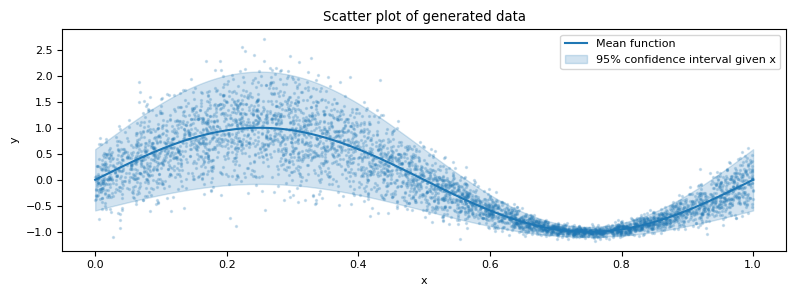

In [3]:
x_grid = np.linspace(0, 1, 1000)

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(x_grid, mean_function(x_grid), color="C0", label="Mean function")
ax.fill_between(
    x_grid,
    mean_function(x_grid) - 1.96 * deviation_function(x_grid),
    mean_function(x_grid) + 1.96 * deviation_function(x_grid),
    color="C0", alpha=0.2, label="95% confidence interval given x")
ax.scatter(X, y, s=2, color="C0", alpha=0.2)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Scatter plot of generated data")
ax.legend()
plt.tight_layout()

## Histograms

The problem of density estimation might seem intimidating, but in practice, it becomes quite familiar once we realize that a histogram (normalized to have an integral of 1) is precisely a technique with this objective. By counting the number of examples in each bin, we are discretizing the distribution so that we can estimate the probability of the regions and obtain a "low resolution" density estimation.

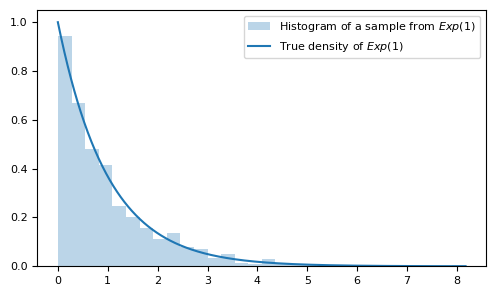

In [4]:
from scipy.stats import expon
hist_sample_example = np.random.RandomState(42).exponential(size=1000)
hist_linspace_example = np.linspace(0, max(hist_sample_example), 1000)
fig, ax = plt.subplots(figsize=(5, 3))
ax.hist(hist_sample_example, bins=30, density=True, color="C0", alpha=0.3, label="Histogram of a sample from $Exp(1)$")
ax.plot(hist_linspace_example, expon().pdf(hist_linspace_example), c="C0", label="True density of $Exp(1)$")
ax.legend()
plt.tight_layout()

However, using all samples gives us a density estimate of $Y$ without any condition on $X$.

We can quickly condition this strategy on $X=x$ by filtering only points that are close to $X=x$ when creating the histogram that will represent that conditional density. The definition of "close points" can vary. For instance, we could use a strategy like `sklearn.neighbors.NearestNeighbors.radius_neighbors`, selecting only the examples that are within a radius of $\varepsilon$ around point $x$, or indeed selecting a fixed number of nearest neighbors with something like `sklearn.neighbors.NearestNeighbors.kneighbors`.

In [5]:
from scipy.stats import rv_histogram, norm
hist = np.histogram(y, bins=np.linspace(- 1.5, 3, 51))
hist_dist = rv_histogram(hist)

def plot_conditional_y_using_near_data(ax, x_value, X, y, c, eps=0.05):
    ax.plot(y_grid_refined, norm(loc=mean_function(x_value), scale=deviation_function(x_value)).pdf(y_grid_refined), "--", color=c, label=f"real $f(y | x = {x_value})$")
    ax.hist(y[(X < x_value + eps) & (X > x_value - eps)], alpha=0.3, bins=y_grid, density=True, color=c, label=f"estimated $f(y | x = {x_value})$ using near data")

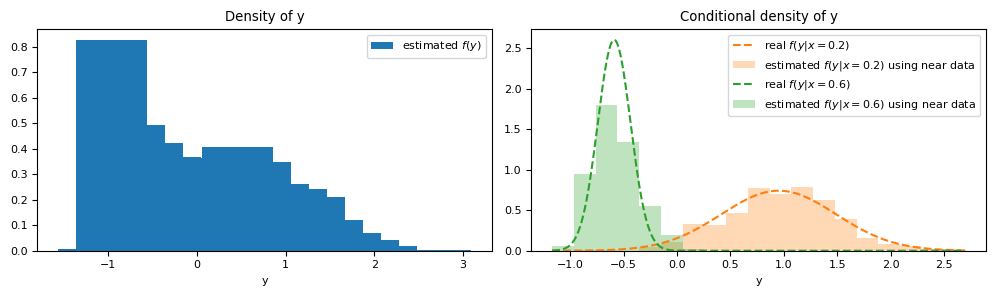

In [6]:
min_y, max_y = min(y), max(y)
y_grid = np.linspace(min_y, max_y, 20)
y_grid_refined = np.linspace(min_y, max_y, 1000)

fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
ax[0].bar(y_grid, hist_dist.pdf(y_grid), label="estimated $f(y)$")
ax[0].set_title("Density of y")
ax[0].set_xlabel("y")
ax[0].legend()

plot_conditional_y_using_near_data(ax=ax[1], x_value=0.2, X=X, y=y, c="C1")
plot_conditional_y_using_near_data(ax=ax[1], x_value=0.6, X=X, y=y, c="C2")
ax[1].set_title("Conditional density of y")
ax[1].set_xlabel("y")
ax[1].legend()

plt.tight_layout()

## Kernel Density Estimation (KDE)

Histograms are great baselines, but for more complex distributions, it can be challenging to determine the appropriate number of bins to use, and we may end up with step-like functions that may not be the most pleasant to work with.

Generally, the problem of non-parametric density estimation is often solved using Kernel Density Estimation, and it makes sense to use it here as well, aligning it with some way to transform the problem into a conditional estimation. The "long story short" of KDE is to place bumps around observed points (shaped like a Gaussian, for example) and add up these bumps, normalizing them to have a density estimate.

$\oint$ _The type of bump (which is called a kernel) and the thickness (bandwidth) of these bumps are some hyperparameters that you can adjust using cross-validation with a likelihood-style metric to see if a test sample really is likely to have been sampled from your estimated density. [[LINK](https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html)]._

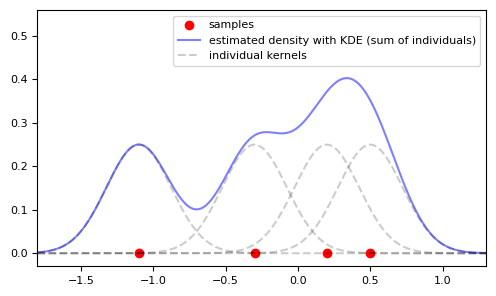

In [7]:
def gaussian_kernel(x, y):
    return np.exp(- (x - y)**2 / 0.1)

def kde(x, S):
    return sum(gaussian_kernel(x, s) for s in S)

S = [-1.1, -0.3, 0.2, 0.5]
grid_kde = np.linspace(-1.8, 1.3, 1000)

fig, ax = plt.subplots(figsize=(5, 3))

ax.scatter(S, [0] * len(S), c='r')
ax.plot(grid_kde, kde(grid_kde, S)/len(S), c='b', alpha=0.5)
[ax.plot(grid_kde, gaussian_kernel(grid_kde, s) / len(S), '--', c='k', alpha=0.2) for s in S]
ax.set_ylim(-0.03, 0.56)
ax.set_xlim(-1.8,1.3)
ax.legend(["samples", "estimated density with KDE (sum of individuals)", "individual kernels"])
plt.tight_layout()

To condition our KDE, we can once again use a neighbor search. By using `sklearn.neighbors.NearestNeighbors` and `sklearn.neighbors.KernelDensity` (without worrying too much about the hyperparameters of this model), we can find the neighbors closest to a certain point, for instance $X=0.2$, and then, with these neighbors, estimate the density.

In [8]:
from sklearn.neighbors import NearestNeighbors, KernelDensity

x_value = 0.2
knn = NearestNeighbors(n_neighbors=100).fit(X.reshape(-1, 1))
_, ind_x_value = knn.kneighbors([[x_value]])

kde = KernelDensity(kernel='gaussian', bandwidth="scott").fit(y[ind_x_value].reshape(-1, 1))

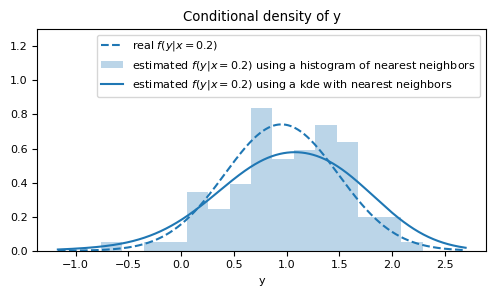

In [9]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(y_grid_refined, norm(loc=mean_function(x_value), scale=deviation_function(x_value)).pdf(y_grid_refined), "--", color="C0", label=f"real $f(y | x = {x_value})$")
ax.hist(y[ind_x_value].ravel(), alpha=0.3, bins=y_grid, density=True, color="C0", label=f"estimated $f(y | x = {x_value})$ using a histogram of nearest neighbors")

ax.plot(y_grid_refined, np.exp(kde.score_samples(y_grid_refined.reshape(-1, 1))), color="C0", label=f"estimated $f(y | x = {x_value})$ using a kde with nearest neighbors")
ax.set_title("Conditional density of y")
ax.set_xlabel("y")
ax.set_ylim(0, 1.3)
ax.legend()
plt.tight_layout()

Notice that this method gives us a much smoother estimate than the histogram.

We can encapsulate this logic in a class with the scikit-learn API, such that the `.predict` method applies the mentioned logic for each requested value (that is, it first searches for the neighbors, and then uses a KDE to get the estimates for each example).

In [10]:
from sklearn.base import BaseEstimator, clone

class ConditionalNearestNeighborsKDE(BaseEstimator):
    """TODO:Conditional Kernel Density Estimation using nearest neighbors.

    This class implements a Conditional Kernel Density Estimation by applying
    the Kernel Density Estimation algorithm after a nearest neighbors search.
    
    It allows the use of user-specified nearest neighbor and kernel density
    estimators or, if not provided, defaults will be used.

    Parameters
    ----------
    nn_estimator : NearestNeighbors instance, default=None
    A pre-configured instance of a `~sklearn.neighbors.NearestNeighbors`
    class to use for finding nearest neighbors. If not specified, a
    `~sklearn.neighbors.NearestNeighbors` instance with `n_neighbors=100`
    will be used.

    kde_estimator : KernelDensity instance, default=None
    A pre-configured instance of a `~sklearn.neighbors.KernelDensity`
    class to use for estimating the kernel density. If not specified,
    a `~sklearn.neighbors.KernelDensity` instance with `bandwidth="scott"`
    will be used.
    """
    def __init__(self, nn_estimator=None, kde_estimator=None):
        self.nn_estimator = nn_estimator
        self.kde_estimator = kde_estimator
        
    def fit(self, X, y=None):
        if self.nn_estimator is None:
            self.nn_estimator_ = NearestNeighbors(n_neighbors=100)
        else:
            self.nn_estimator_ = clone(self.nn_estimator)
        self.nn_estimator_.fit(X, y)
        self.y_train_ = y
        return self
    
    def predict(self, X):
        """Predict the conditional density estimation of new samples.

        The predicted density of the target for each sample in X is returned.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Vector to be estimated, where `n_samples` is the number of samples
            and `n_features` is the number of features.

        Returns
        -------
        kernel_density_list : list of len n_samples of KernelDensity instances
            Estimated conditional density estimations in the form of
            `~sklearn.neighbors.KernelDensity` instances.
        """
        _, ind_X = self.nn_estimator_.kneighbors(X)
        if self.kde_estimator is None:
            kernel_density_list = [KernelDensity(bandwidth="scott").fit(self.y_train_[ind].reshape(-1, 1)) for ind in ind_X]
        else:
            kernel_density_list = [clone(self.kde_estimator).fit(self.y_train_[ind].reshape(-1, 1)) for ind in ind_X]
        return kernel_density_list

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

ckde = ConditionalNearestNeighborsKDE().fit(X_train.reshape(-1, 1), y_train)
ckde_preds = ckde.predict(X_test.reshape(-1, 1))

## Evaluating the performance of our conditional density estimation

Clearly, the usual regression metrics are difficult to apply here directly, requiring an approach specific to the problem we are dealing with. This discussion is a bit denser, but important for us to evaluate our estimators.

$\oint$ _Some conformal prediction metrics can be used here, such as the "how many times the observed target falls within a confidence interval", if you make confidence intervals from the estimated conditional densities. But again, metrics inherent to the nature of the problem are more appropriate._

Let $f(y \,|\, X=x)$ be the real conditional probability density of the problem, and $\hat{f}(y \,|\, X=x)$ be the estimated density. We want to see how close these two functions are, with the detail that we don't have $f(y | x)$. A clever way to deal with this is to calculate the mean square error of the difference:

$$ L(f, \hat{f}) = \mathbb{E}\left( \int \left( \hat{f}(y \,|\, X) - f(y \,|\, X) \right)^2 dy \right) = \int \int \left( \hat{f}(y \,|\, X=x) - f(y \,|\, X=x) \right)^2  dy \, f(x) \, dx.$$

$\oint$ _This metric has a slightly different interpretation than the mean square error as empirical risk for our point estimates $h(x)$. When we do $\frac{1}{n} \sum_{i=1}^n \left( h(x_i) - y_i \right)$, we are actually estimating_

$$\mathbb{E}\left( h(X) - Y \right) = \int \int \left( h(x) - y \right)^2 f(x,y) \, dx \, dy.$$

_In the metric $L$ we are averaging only in relation to $X$ in such a way that we want, fixed $X=x$, $\hat{f}(y \,|\, X=x)$ to approximate well $f(y \,|\, X=x)$ for all possible values of $y$ uniformly in $\mathbb{R}$._

By distributing $L$, we get

$$ L(f, \hat{f}) = \int \int \left( \hat{f}(y \,|\, X=x) \right)^2 f(x) \, dy \, dx + \int \int -2\hat{f}(y \,|\, X=x) f(y, x) dx dy + C,$$

since $f(x,y) = f(y \,|\, x) f(x)$ and defining $C = \int \int \left( f(y \,|\, x) \right)^2 f(x) \, dy \, dx$. Since $C$ is a constant that does not depend on the estimation method of $\hat{f}$, it can be ignored when comparing models.

The first term can be written as

$$ \int \left( \int \left( \hat{f}(y \,|\, X=x) \right)^2\, dy \right) f(x)  \, dx, $$

so the interior integral can be calculated with some numerical integration method and the integral in x can be estimated with an empirical average in a validation sample $S=(x_i, y_i)_{i=1}^n$. Explicitly, we have

$$ \frac{1}{n} \sum_{i=1}^n \left( \int  \left( \hat{f}(y \,|\, X=x_i) \right)^2 \, dy \right). $$

While the second can be directly estimated as the empirical average

$$ \frac{-2}{n} \sum_{i=1}^n \hat{f}(y_i \,|\, X=x_i) $$

also in $S$.

Our estimates allow us to compute a model comparison metric given by 

$$ L(f, \hat{f}, S) \approx \hat{L}(f, \hat{f}, S) = \frac{1}{n} \sum_{i=1}^n \left( \int  \left( \hat{f}(y \,|\, X=x_i) \right)^2 \, dy \right) - \frac{2}{n} \sum_{i=1}^n \hat{f}(y_i \,|\, X=x_i),$$

where a good model should have it as small as possible.

We can implement it in such a way that it takes previously calculated density estimates and performs the necessary operations (both integration and summation). For the integral, we are explicitly requesting a `y_grid` where it will be estimated with `sklearn.metrics.auc`.

In [12]:
from sklearn.metrics import auc, make_scorer
from joblib import Parallel, delayed

def squared_loss(y_true, cde_preds, y_grid, n_jobs=-1):
    """
    Average squared loss between the true and predicted conditional probabilities.

    This method can be used to assess the quality of the conditional probability
    density function fit.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        The true values of y for each sample.

    cde_preds : list of len n_samples of KernelDensity instances
        The predicted conditional densitys. Each instance should be a fitted
        KernelDensity instance.

    y_grid : array-like of shape (n_samples,)
        The grid of y values used for computing the area under the curve
        (AUC) for the squared PDF.

    n_jobs : int, optional
        The number of jobs to run in parallel. '-1' means using all processors.

    Returns
    -------
    average_squared_loss: float
        The average squared loss between the true and predicted conditional
        probability density functions. Note that it is always off by C.
    """
    def _compute_individual_loss(y_, cde_pred):
        # The score_samples and score methods returns stuff on log scale,
        # so we have to exp it.
        squared_auc = auc(y_grid, np.exp(cde_pred.score_samples(y_grid.reshape(-1, 1)))**2)
        expected_value = np.exp(cde_pred.score([[y_]]))
        return squared_auc - 2 * expected_value

    individual_squared_loss = Parallel(n_jobs=n_jobs)(
        delayed(_compute_individual_loss)(y_, cde_pred) for y_, cde_pred in zip(y_true, cde_preds)
    )

    average_squared_loss = sum(individual_squared_loss) / len(y_true)
    return average_squared_loss

Applying it to the previous data, we have a way to quantify how well we are performing the task of CDE.

In [13]:
squared_loss(y_test, ckde_preds, np.linspace(-5, 5, 1000))

-0.8507158015517423

For comparison purposes, we can compare it with the density estimation of $Y$ without taking into account the conditionality, that is, we can train the KDE on all the training data.

In [14]:
squared_loss(y_test, len(y_test)*[KernelDensity(bandwidth="scott").fit(y_train.reshape(-1, 1))], np.linspace(-5, 5, 1000))

-0.4007238630119935

Since the previous value is lower, we conclude that it is a better density estimation, as expected.

$\oint$ _This metric is interesting for comparing models, but it might be hard to interpret from a business standpoint. In this case, I understand that trying to transform your distribution forecast into a point forecast to calculate some traditional metric such as `sklearn.metrics.mean_absolute_error` (or even conformal prediction metrics) could be a way to circumvent the problem for a more palatable interpretation._

Having a way to compare models, it's natural to want to optimize hyperparameters with something like `sklearn.model_selection.GridSearchCV`. Since we built the `ConditionalNearestNeighborsKDE` following the sklearn standard, and the metric in a way that it receives the output from a `.predict`, we can simply use `sklearn.model_selection.GridSearchCV` to optimize how we want `sklearn.neighbors.NearestNeighbors` to be, for example.

In [15]:
from functools import partial
from sklearn.model_selection import GridSearchCV

squared_loss_score = make_scorer(partial(squared_loss, y_grid=np.linspace(-5, 5, 1000)), greater_is_better=False)

param_grid = {
    "nn_estimator": [NearestNeighbors(n_neighbors=n_neighbors) for n_neighbors in [100, 500, 1000]],
}

gs = (
    GridSearchCV(
        ConditionalNearestNeighborsKDE(),
        param_grid=param_grid,
        scoring=squared_loss_score)
    .fit(X_train.reshape(-1, 1), y_train)
)

(
    pd.DataFrame(gs.cv_results_)
    .filter(["param_nn_estimator", "mean_score_time", "mean_test_score", "std_test_score"])
    .sort_values(by="mean_test_score", ascending=False)
    .reset_index(drop=True)
)

,param_nn_estimator,mean_score_time,mean_test_score,std_test_score
0,NearestNeighbors(n_neighbors=500),6.718035,0.866858,0.015677
1,NearestNeighbors(n_neighbors=100),1.919691,0.845465,0.016176
2,NearestNeighbors(n_neighbors=1000),11.963328,0.699505,0.013646


In this case, we obtain a better score than the previous one using any values of neighbors. We may still be interested in the aspects of kernel estimation, and this could further improve the result.

In [16]:
squared_loss(y_test, gs.best_estimator_.predict(X_test.reshape(-1, 1)), np.linspace(-5, 5, 1000))

-0.9276598435770342

This structure was presented because it is more intuitive, however, in higher dimensions or in scenarios with lots of data, the neighbor search has some problems. First, it is computationally costly as it involves distance comparisons. Second, we can easily be at the mercy of different scales of variables, possibly with categorical variables. Third, we may have many less informative variables in $X$ and consequently suffer from the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality), with our neighbors becoming increasingly distant and less representative. In a real problem, you may have hundreds of covariates that you might be interested in conditioning on and millions of examples, so this strategy may not be the most suitable.


## LeafNeighbors

Existe uma forma de tentar driblar o problema da busca de vizinhos com dimensionalidade alta com variáveis irrelevantes e de escalas e tipos variados. Essa maneira é criar uma métrica de distância mais apropriada que seja robusta a isso.

Pela forma como o treinamento de árvores é feito, elas são naturalmente boas para lidar com esses problemas uma vez que: aprendem bem quais são as features importantes pelo processo de escolha do melhor split; não se preocupam com escala das variáveis uma vez que, no treinamento, olham apenas para ordenação.

Ao treinar um bagging de árvores, temos uma variabilidade de quebras do espaço de features que permite que usemos a coocorrência nas mesmas folhas como uma métrica de similaridade dos exemplos.

Portanto, se treinamos um modelo de bagging de árvores de regressão estilo `sklearn.ensemble.RandomForestRegressor` ou `sklearn.ensemble.ExtraTreesRegressor` para prever $Y$ a partir de $X$ estaremos naturalmente construindo árvores que fazem quebras em variáveis relevantes para o problema de previsão de $Y$ ao mesmo tempo que, contando as coocorrências de folhas nos diferentes modelos do bagging apenas, não nos preocupamos com as diferentes escalas pois consideramos similar todos que ocorrem na mesma folha.

Podemos implementar uma classe de busca de vizinhos que segue essa lógica, nos padrões do scikit-learn como:

In [17]:
from sklearn.neighbors._base import NeighborsBase
from sklearn.ensemble import RandomForestRegressor

class LeafNeighbors(NeighborsBase):
    """Neighbors search using shared leaf nodes in a tree ensemble as a similarity measure.
    
    This class implements a supervised neighbor search using the leafs of an ensemble tree
    estimator as a measure of distance. Examples that occur simultaneously in several sheets
    are naturally close in variables relevant to the target.

    Parameters
    ----------
    tree_ensemble_estimator : ForestRegressor instance, default=None
        The ensemble tree estimator to use. If None, a `~sklearn.ensemble.RandomForestRegressor`
        with `max_depth=10` will be used.
    
    n_neighbors : int, default=5
        Number of neighbors to use in the neighbor-based learning method.
    
    random_state : int, RandomState instance or None, default=None
        Controls the randomness of the ensemble tree estimator. Pass an int for reproducible
        output across multiple function calls.
    """
    def __init__(self, tree_ensemble_estimator=None, n_neighbors=5, random_state=None):
        self.tree_ensemble_estimator = tree_ensemble_estimator
        self.n_neighbors = n_neighbors
        self.random_state = random_state
        
    def fit(self, X, y=None):
        if self.tree_ensemble_estimator is None:
            self.tree_ensemble_estimator = RandomForestRegressor(max_depth=10, random_state=self.random_state)
        else:
            self.tree_ensemble_estimator = clone(self.tree_ensemble_estimator)

        self.nn_estimator_ = NearestNeighbors(n_neighbors=self.n_neighbors, metric="hamming")

        self.tree_ensemble_estimator.fit(X, y)
        leafs_X = self.tree_ensemble_estimator.apply(X)
        self.nn_estimator_.fit(leafs_X)
        return self
    
    def kneighbors(self, X):
        leafs_X = self.tree_ensemble_estimator.apply(X)
        return self.nn_estimator_.kneighbors(leafs_X)
    
    def radius_neighbors(self, X):
        leafs_X = self.tree_ensemble_estimator.apply(X)
        return self.nn_estimator_.radius_neighbors(leafs_X)

E utilizá-la dentro do nosso `ConditionalNearestNeighborsKDE`, definind o parâmetro `nn_estimator` com essa nossa nova busca.

In [18]:
crfkde = (
    ConditionalNearestNeighborsKDE(nn_estimator=LeafNeighbors(n_neighbors=100))
    .fit(X_train.reshape(-1, 1), y_train)
)
crfkde_preds = crfkde.predict(X_test.reshape(-1, 1))

squared_loss(y_test, crfkde_preds, np.linspace(-5, 5, 1000))

-0.8447973436184383

Nesse caso, a métrica ficou parecida com a encontrada no problema anterior com vizinhos já que a dimensão é baixa. Portanto, os vizinhos encontrados na reta praticamente coincidir com a busca de vizinhos próximos usual.

## FlexCode

O FlexCode vem para tentar contornar os problemas anteriores abordando o CDE de uma maneira completamente diferente: utilizando argumentos de álgebra linear para estimar a função densidade de probabilidade condicional a partir de uma base de funções.

O espaço das [funções quadrado integráveis](https://mathworld.wolfram.com/L2-Space.html) ($L^2(\mathbb{R})$) é um espaço vetorial com produto interno definido por $\left\langle g, h\right\rangle = \int_{\mathbb{R}} g(t)\, h(t) \, dt$.  E, assim como em espaços vetoriais de dimensão finita usuais, tem uma base (nesse caso, infinita) $\left\{ \phi_i \in L^2(\mathbb{R}) : i \in \mathbb{N}\right\}$ tal que qualquer $g \in L^2(\mathbb{R})$ pode ser escrito como uma combinação linear dos elementos da base, ou seja, $g(t) = \sum_{i=1}^\infty \beta_i \phi_i(t)$, $\forall t \in \mathbb{R}$. É possível forçar ainda que a nossa base seja ortonormal (de forma que $\left\langle \phi_i, \phi_j\right\rangle = \delta_{i,j}$ (ou seja, vale $1$ se $i = j$ e $0$ caso contrário).

$\oint$ _Para criar a intuição de que isso faz sentido, caso você nunca tenha visto, pense em como estamos num cenário similar às aplicações de [séries de Fourier](https://en.wikipedia.org/wiki/Fourier_series)._

Com qualquer base ortonormal $\left\{ \phi_i \right\}$ fixada, é possível escrever

$$f(y \,|\, X=x) = \sum_{i=1}^\infty \beta_i(x)\, \phi_i(y),$$

em que estamos colocando a dependência de $X=x$ diretamente nos coeficientes da combinação linear.

Repare que, de $\left\{ \phi_i \right\}$ ser uma base ortornormal, então

$$
\begin{align}
    \mathbb{E}\left( \phi_j(Y) \,|\, X=x \right) &= \int_\mathbb{R} \phi_j(y) \,f(y \,|\, X=x) \,dy\\
    &= \int_\mathbb{R} \phi_j(y) \sum_{i=1}^\infty \beta_i(x)\, \phi_i(y) \,dy\\
    &= \sum_{i=1}^\infty \beta_i(x) \int_\mathbb{R} \phi_j(y) \, \phi_i(y) \,dy\\
    &= \sum_{i=1}^\infty \beta_i(x) \,\delta_{i,j} = \beta_j(x).
\end{align}
$$

Portanto, $\hat{\beta}_j(x)$ pode ser estimado com uma regressão utilizando $X$ para prever $\phi_j(Y)$.

O algoritmo [FlexCode](https://pypi.org/project/flexcode/) se propões a fazer justamente isso. Utilizando alguma base `basis_system` (hiperparâmetro do modelo), os coeficientes são estimados a partir dessas regressões de $\phi_j(Y)$. Como, naturalmente fazer a soma infinita é inviável, ela é trunca no valor `max_basis` $I$ (que pode ser achado via validação cruzada, encarado como hiperparâmetro). Temos portanto

$$ \hat{f}(y \,|\, X=x) = \sum_{i=1}^I \hat{\beta}_i(x) \, \phi(y).$$

## FlexCode no Python

Para utilizá-lo, definimos o modelo de regressão, parâmetros dele, além dos outros hiperparâmetros mencionados anteriormente.

In [19]:
from flexcode.regression_models import RandomForest
from flexcode import FlexCodeModel

flexcode_model = FlexCodeModel(RandomForest, basis_system="cosine", max_basis=31, regression_params={'max_depth': 5, 'n_estimators': 100})
flexcode_model.fit(X_train, y_train)

O output desse estimador, da maneira que está implementado, nos retorna o valor de $\hat{f}(y \,|\, X=x)$ num grid de valores de $y$.

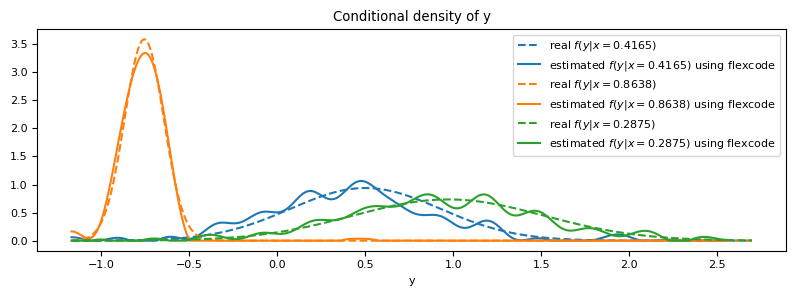

In [20]:
cdes, y_grid_flexcode = flexcode_model.predict(X_test, n_grid=400)
y_grid_flexcode = y_grid_flexcode.reshape(-1)

fig, ax = plt.subplots(figsize=(8, 3))
for c, sample_index in enumerate(np.random.RandomState(0).choice(len(X_test), size=3)):
    x_value = np.round(X_test[sample_index], 4)
    ax.plot(y_grid_refined, norm(loc=mean_function(x_value), scale=deviation_function(x_value)).pdf(y_grid_refined), "--", color=f"C{c}", label=f"real $f(y | x = {x_value})$")
    ax.plot(y_grid_flexcode, cdes[sample_index], color=f"C{c}", label=f"estimated $f(y | x = {x_value})$ using flexcode")
ax.set_title("Conditional density of y")
ax.set_xlabel("y")
ax.legend()
plt.tight_layout()

Para avaliar o estimador, como construímos anteriormente nossa métrica de forma que ela recebe um objeto estilo o `sklearn.neighbors.KernelDensity`, em particular precisamos que ele tenha alguns métodos específicos que podemos implementar, adaptando o output do `flexcode.FlexCodeModel` para esse formato.

In [21]:
class FlexCode_return_to_DensityEstimator:
    def __init__(self, y_grid, pdf_values):
        self.y_grid = y_grid
        self.pdf_values = pdf_values
        self.density = rv_histogram((pdf_values, np.hstack([y_grid, [y_grid[-1] + y_grid[-1] - y_grid[-2]]])))

    def score_samples(self, X):
        return np.log(self.density.pdf(X))
    
    def score(self, X):
        return np.sum(self.score_samples(X))

In [22]:
density_estimation_preds_flexcode = [FlexCode_return_to_DensityEstimator(y_grid=y_grid_flexcode, pdf_values=cde) for cde in cdes]
squared_loss(y_test, density_estimation_preds_flexcode, np.linspace(-5, 5, 1000))

-1.6340682167735636

Nesse caso, obtemos uma métrica bem melhor que o KDE baseado em vizinhos mais próximos anterior.

## Aplicando num problema real

Vamos aplicar nossas diferentes técnicas em um problema de regressão real, sem uma construção artificial, para estudar como as nossas diferentes abordagens discutidas performam.

In [23]:
from sklearn.datasets import fetch_california_housing

X_california, y_california = fetch_california_housing(return_X_y=True)
X_california_train, X_california_test, y_california_train, y_california_test = train_test_split(
    X_california, y_california, test_size=0.33, random_state=42)
print(f"X dimension: {X_california.shape[1]}")

X dimension: 8


In [24]:
ckde_california = ConditionalNearestNeighborsKDE().fit(X_california_train, y_california_train)
ckde_california_preds = ckde_california.predict(X_california_test)

squared_loss(y_california_test, ckde_california_preds, np.linspace(0, 6, 1000))

-0.2948159711962537

In [25]:
crfkde_california = ConditionalNearestNeighborsKDE(nn_estimator=LeafNeighbors(n_neighbors=100)).fit(X_california_train, y_california_train)
crfkde_california_preds = crfkde_california.predict(X_california_test)

squared_loss(y_california_test, crfkde_california_preds, np.linspace(0, 6, 1000))

-0.5763952709823481

In [26]:
model_california = FlexCodeModel(RandomForest, max_basis=31, regression_params={'max_depth': 10, 'n_estimators': 100})
model_california.fit(X_california_train, y_california_train)

cdes_california, y_grid_california = model_california.predict(X_california_test, n_grid=400)
y_grid_california = y_grid_california.reshape(-1)
density_estimation_preds_flexcode_california = [FlexCode_return_to_DensityEstimator(y_grid=y_grid_california, pdf_values=cde) for cde in cdes_california]

squared_loss(y_california_test, density_estimation_preds_flexcode_california, np.linspace(0, 6, 1000))

-1.2723974671440479

C:\Users\carlo\AppData\Local\anaconda3\lib\site-packages\joblib\_memmapping_reducer.py:607: UserWarning: Failed to delete temporary folder: C:\Users\carlo\AppData\Local\Temp\joblib_memmapping_folder_59792_22db84709e4c405aa429102129e189ba_f0047ee74b67497281545b735f2d8861
  warnings.warn("Failed to delete temporary folder: {}"
C:\Users\carlo\AppData\Local\anaconda3\lib\site-packages\joblib\_memmapping_reducer.py:607: UserWarning: Failed to delete temporary folder: C:\Users\carlo\AppData\Local\Temp\joblib_memmapping_folder_59792_b8dd47e2607649348a0d9ad636c0ae5e_c81ea107f4734b19a987ca7a90c6cf1d
  warnings.warn("Failed to delete temporary folder: {}"
C:\Users\carlo\AppData\Local\anaconda3\lib\site-packages\joblib\_memmapping_reducer.py:607: UserWarning: Failed to delete temporary folder: C:\Users\carlo\AppData\Local\Temp\joblib_memmapping_folder_59792_22db84709e4c405aa429102129e189ba_2ec2e755f15a4adf93c723cad192dd3a
  warnings.warn("Failed to delete temporary folder: {}"
C:\Users\carlo\AppD

Vemos que, de fato, a busca de vizinhos com o `LeafNeighbors` superou a busca de vizinhas usual no nosso método de `ConditionalNearestNeighborsKDE`, entretanto o `flexcode.FlexCodeModel` tem resultados superiores aos dois.

___

## Considerações finais

Olhar para o problema de regressão além da estimativa pontual é desafiador, mas te dá informações mais ricas que podem ajudar no seu processo de decisão. Apesar de importante, é uma área pouco ativa em termos de comunidade, mas que prevejo ganhando mais atenção conforme as pessoas conheçam. É natural que, atualmente, as bibliotecas que tentam abordar esse problema tenham alguns bugs que vão sendo resolvidos ao longo do tempo. É importante, portanto, utilizar com esse cuidado e reportando qualquer comportamento que pareça estranho.

$\oint$ _Me importei em mencionar o método baseado em vizinhos das árvores porque é possível adaptar o treinamento da árvore de uma maneira específica para o problema de CDE. De forma usual num problema de regressão, a nossa árvore vai estar tentando otimizar alguma métrica estilo `sklearn.metrics.mean_squared_error` na hora de construir seus splits. Entretanto, é possível tentar otimizar diretamente nos splits alguma métrica de CDE como a `squared_error` que discutimos anteriormente. É isso que o método [RFCDE (Random Forests for Conditional Density Estimation)](https://github.com/lee-group-cmu/RFCDE) se propõe a fazer. A implementação em Python foi feita pelos mesmos contribuidores que adaptaram o código de FlexCode do [R](https://github.com/rizbicki/FlexCoDE) para o [Python](https://github.com/lee-group-cmu/FlexCode)._

## TO DO:

- Terminar de traduzir.

- Garantir que tá no formato com links pros estimadores do sklearn. Rodar um flake8. Docstring tbm por exemplo.


Referencias:

outras que eu coloquei la em cima.

https://gdmarmerola.github.io/forest-embeddings/

https://projecteuclid.org/journals/electronic-journal-of-statistics/volume-11/issue-2/Converting-high-dimensional-regression-to-high-dimensional-conditional-density-estimation/10.1214/17-EJS1302.full

https://arxiv.org/abs/1804.05753

https://jmlr.csail.mit.edu/papers/volume7/meinshausen06a/meinshausen06a.pdf